# ***Operational research Project: Genetic Algorithm for Optimization Of Supply Chain Logistics Network***
## Rahma Idris


##Supervised by: Pr. Yassine Hachaichi

---

(Attached with a doc explaining the process)

In [ ]:
import random
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define the main function
def main():
    global pro, man, exp, log, imp, distij, demand, distjk, distli, distlj, distlk, lstock, linv_c, binv_c, pop_size, gen_loc, max_gen, production_cost_per_unit, best_cost
    max_gen = 20
    gen_loc = 4
    pop_size = 12
    pro, man, exp, log, imp = 6, 4, 3, 4, 3
    distij = [[30, 70, 85, 60], [55, 75, 80, 65], [45, 25, 55, 35], [85, 45, 60, 50], [55, 50, 40, 60], [65, 40, 50, 45]]
    distjk = [[650, 720, 810], [640, 750, 800], [710, 820, 780], [690, 760, 790]]
    distli = [[20, 50, 100, 120, 85], [60, 55, 25, 40, 35], [110, 80, 55, 60, 25], [130, 100, 90, 80, 55]]
    distlj = [[60, 85, 90, 70], [55, 25, 35, 50], [75, 65, 40, 55], [95, 80, 60, 45]]
    distlk = [[600, 700, 800], [620, 750, 780], [710, 820, 850], [690, 770, 810]]
    lstock = [[80, 100, 120, 110, 130, 140], [150, 160, 180, 170, 200, 210], [90, 100, 110, 105, 120, 130], [50, 55, 65, 60, 70, 75], [220, 240, 260, 250, 280, 300], [570, 620, 680, 670, 760, 820]]
    demand = [60000, 70000, 75000, 80000, 85000, 90000]
    linv_c = 25
    binv_c = 120
    production_cost_per_unit = 45



    best_costs = genetic_algo()
    linear_resolution()
    plot_convergence(best_costs)

In [ ]:
# Initialize population for the genetic algorithm
def init_pop():
    population = []
    for _ in range(pop_size):
        individual = [[random.randint(80, 180) for _ in range(man)] for _ in range(pro)]
        population.append(individual)
    return population


In [ ]:
# Calculate the total cost for an individual
def calculate_total_cost(individual):
    total_cost = 0
    for i in range(len(individual)):
        for j in range(len(individual[i])):
            total_cost += individual[i][j] * production_cost_per_unit * distij[i][j]
    inventory_holding_cost = sum(demand) * linv_c
    total_cost += inventory_holding_cost
    return total_cost


In [ ]:
# Evaluate the fitness of an individual
def evaluate_fitness(individual):
    return 1 / (calculate_total_cost(individual) + 1)


In [ ]:
# Select an individual from the population
def select(population):
    fitness_values = [evaluate_fitness(ind) for ind in population]
    total_fitness = sum(fitness_values)
    selection_probs = [fitness / total_fitness for fitness in fitness_values]
    return population[np.random.choice(len(population), p=selection_probs)]

In [ ]:
# Perform crossover between two parents
def crossover(parent1, parent2):
    crossover_point = random.randint(1, man - 1)
    child1 = [parent1[i][:crossover_point] + parent2[i][crossover_point:] for i in range(pro)]
    child2 = [parent2[i][:crossover_point] + parent1[i][crossover_point:] for i in range(pro)]
    return child1, child2

In [ ]:
# Mutate an individual
def mutate(individual):
    for i in range(pro):
        if random.random() < 0.2:
            mutation_point = random.randint(0, man - 1)
            individual[i][mutation_point] = random.randint(80, 180)
    return individual

In [ ]:
# Generate offspring for the next generation
def offspring(population, generation):
    new_population = []
    for _ in range(pop_size // 2):
        parent1 = select(population)
        parent2 = select(population)
        child1, child2 = crossover(parent1, parent2)
        child1 = mutate(child1)
        child2 = mutate(child2)
        new_population.append(child1)
        new_population.append(child2)
    return new_population


In [ ]:
# Genetic algorithm
def genetic_algo():
    global best_cost, best_solution
    rand_pop = init_pop()
    best_cost = float('inf')
    best_solution = None
    best_costs = []

    for i in range(max_gen):
        print(f'Generation: {i}')
        if i == 0:
            search = offspring(rand_pop, i)
        else:
            search = offspring(children, i)
        children = search

        for individual in children:
            cost = calculate_total_cost(individual)
            if cost < best_cost:
                best_cost = cost
                best_solution = individual

        best_costs.append(best_cost)
        print(f'Best Cost: {best_cost}')
        print(f'Best Solution: {best_solution}')

    return best_costs

In [ ]:
# Plot the convergence of the GA
def plot_convergence(best_costs):
    plt.figure(figsize=(10, 6))
    plt.plot(best_costs, marker='o')
    plt.title('Genetic Algorithm Convergence')
    plt.xlabel('Generation')
    plt.ylabel('Best Cost')
    plt.grid(True)
    plt.show()

In [ ]:
# Linear programming resolution
def linear_resolution():
    # Define LP objective coefficients
    c = []
    for i in range(pro):
        for j in range(man):
            c.append(production_cost_per_unit * distij[i][j])

    # Define LP inequality constraints (production capacities)
    A_ub = []
    b_ub = []
    for j in range(man):
        for k in range(pro):
            constraint = [0] * (pro * man)
            constraint[k * man + j] = 1
            A_ub.append(constraint)
            b_ub.append(lstock[k][j])

    # Define LP equality constraints (demand satisfaction)
    A_eq = []
    b_eq = []
    for i in range(pro):
        constraint = [0] * (pro * man)
        for j in range(man):
            constraint[i * man + j] = 1
        A_eq.append(constraint)
        b_eq.append(demand[i])

    # Solve LP problem
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(80, 180))

    # Handle cases where LP solver fails
    if res.success:
        lp_cost = res.fun
        print("Linear Programming Total Cost:", lp_cost)
    else:
        lp_cost = None
        print("Linear Programming did not find a solution")

    # Compare LP solution with GA solution
    ga_best_cost = best_cost  # Assuming 'best_cost' is the best cost obtained from the GA
    print("Genetic Algorithm Best Total Cost:", ga_best_cost)

    if lp_cost is not None:
        if lp_cost < ga_best_cost:
            print("Linear Programming provides a better solution.")
        elif lp_cost > ga_best_cost:
            print("Genetic Algorithm provides a better solution.")
        else:
            print("Both Linear Programming and Genetic Algorithm provide equivalent solutions.")
    else:
        print("Comparison not possible as LP did not find a solution.")

In [ ]:
# Visualization of initial situation
def visualize_initial_situation():
    # Plot distance matrices
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    sns.heatmap(distij, ax=axes[0, 0], cmap='viridis', annot=True)
    axes[0, 0].set_title('Distance from Plants to Manufacturing Centers')
    axes[0, 0].set_xlabel('Manufacturing Centers')
    axes[0, 0].set_ylabel('Plants')

    sns.heatmap(distjk, ax=axes[0, 1], cmap='viridis', annot=True)
    axes[0, 1].set_title('Distance from Manufacturing Centers to Export Centers')
    axes[0, 1].set_xlabel('Export Centers')
    axes[0, 1].set_ylabel('Manufacturing Centers')

    sns.heatmap(distli, ax=axes[0, 2], cmap='viridis', annot=True)
    axes[0, 2].set_title('Distance from Logistics Centers to Plants')
    axes[0, 2].set_xlabel('Plants')
    axes[0, 2].set_ylabel('Logistics Centers')

    sns.heatmap(distlj, ax=axes[1, 0], cmap='viridis', annot=True)
    axes[1, 0].set_title('Distance from Logistics Centers to Manufacturing Centers')
    axes[1, 0].set_xlabel('Manufacturing Centers')
    axes[1, 0].set_ylabel('Logistics Centers')

    sns.heatmap(distlk, ax=axes[1, 1], cmap='viridis', annot=True)
    axes[1, 1].set_title('Distance from Logistics Centers to Export Centers')
    axes[1, 1].set_xlabel('Export Centers')
    axes[1, 1].set_ylabel('Logistics Centers')

    plt.tight_layout()
    plt.show()

    # Plot stock levels
    plt.figure(figsize=(10, 6))
    plt.boxplot(lstock, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    plt.title('Initial Stock Levels at Locations')
    plt.xlabel('Locations')
    plt.ylabel('Stock Level')
    plt.grid(True)
    plt.show()

    # Plot demand
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(demand)), demand, color='blue')
    plt.title('Demand at Each Production Site')
    plt.xlabel('Production Sites')
    plt.ylabel('Demand')
    plt.grid(True)
    plt.show()




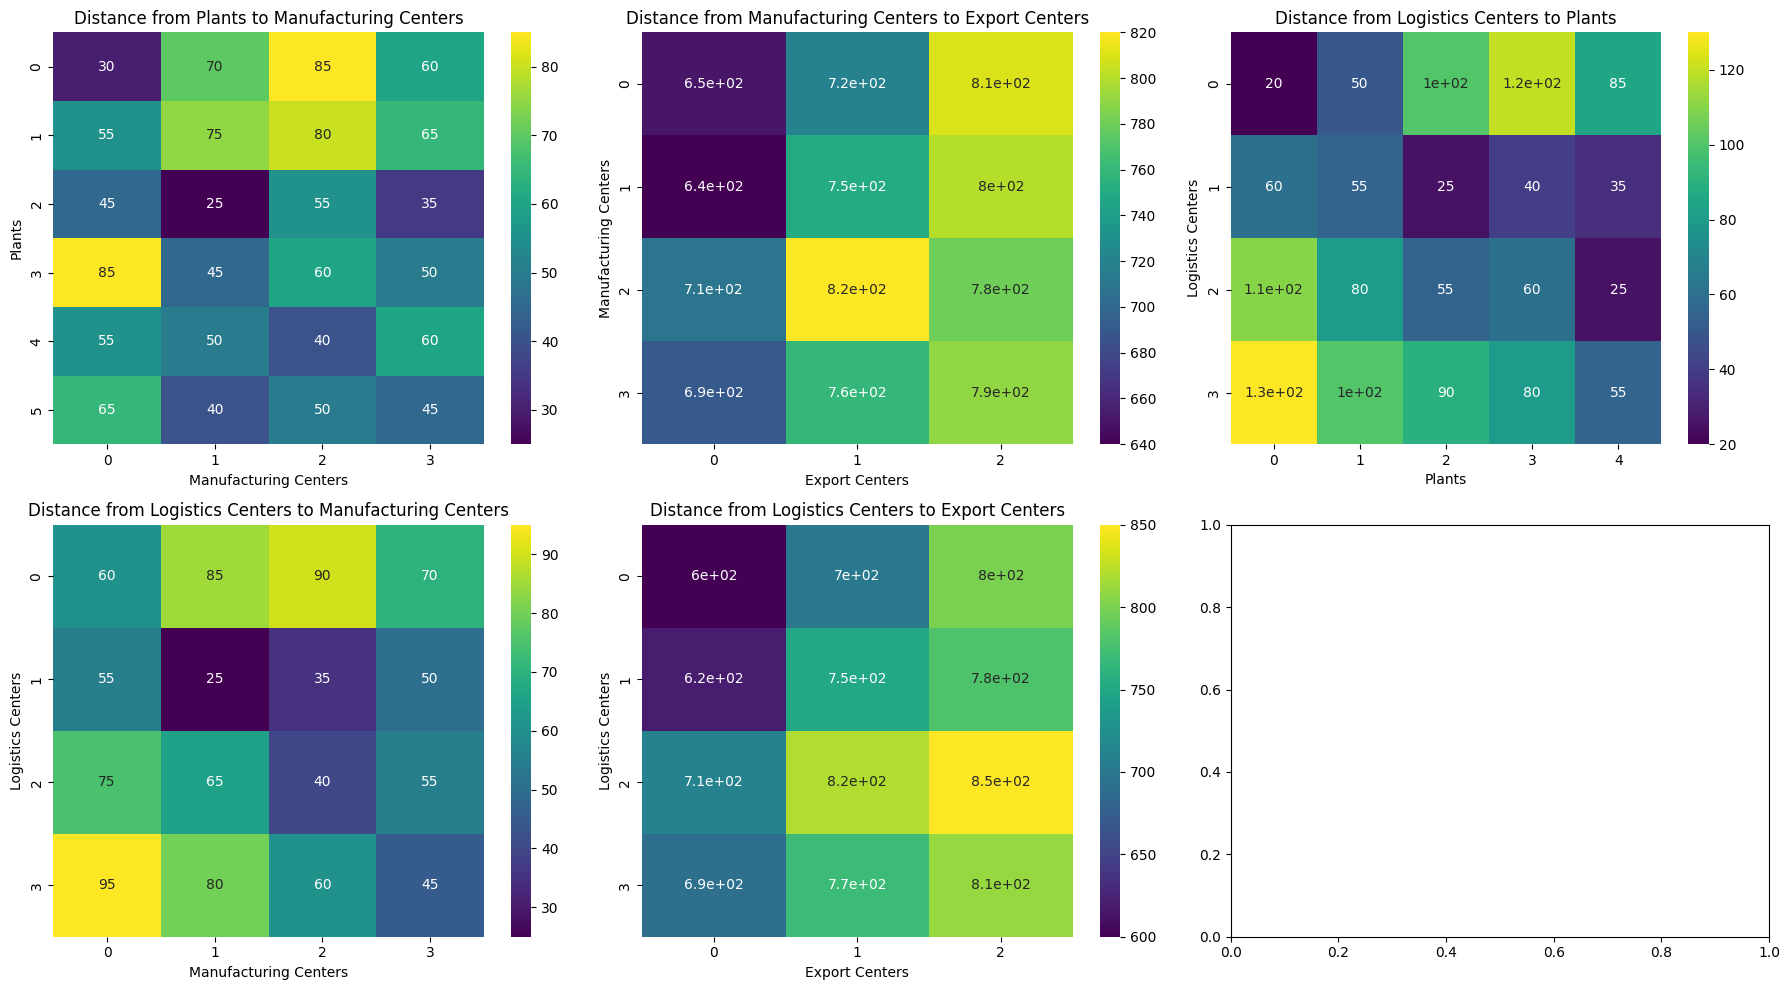

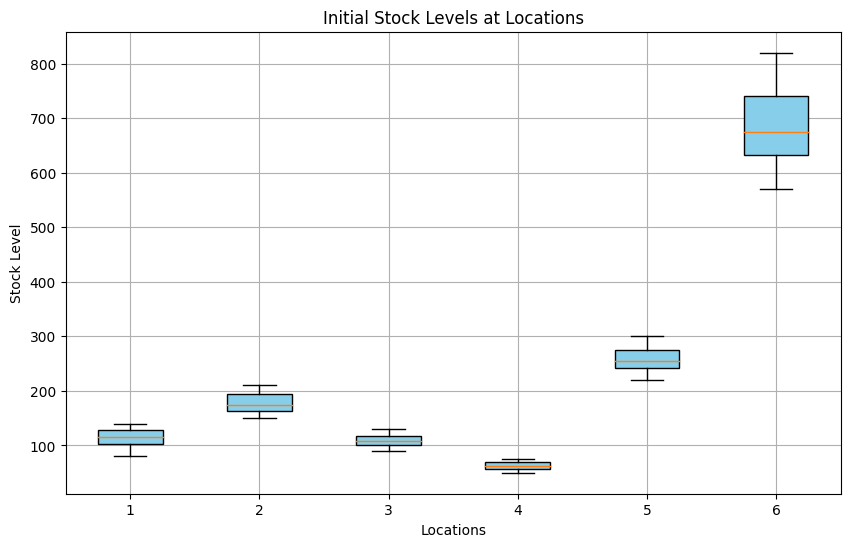

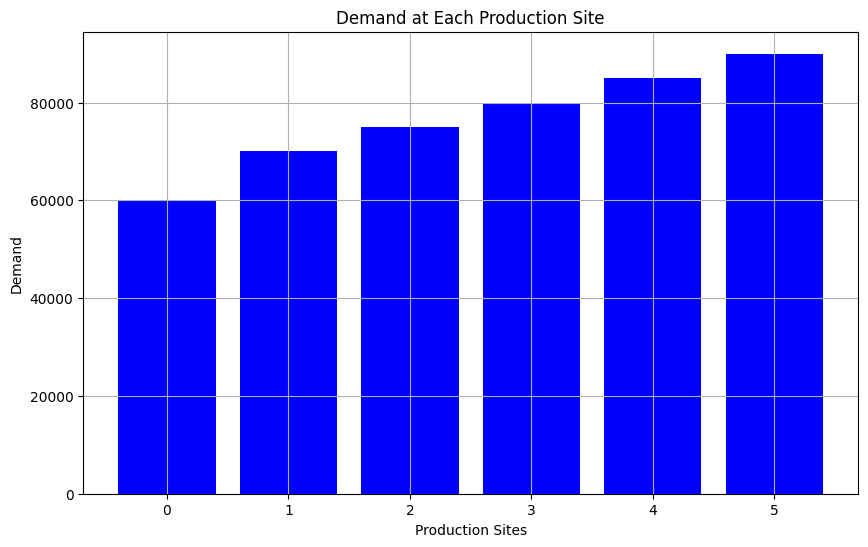

In [ ]:
visualize_initial_situation()


Generation: 0
Best Cost: 18274975
Best Solution: [[139, 122, 115, 124], [116, 90, 84, 122], [100, 151, 150, 107], [86, 101, 142, 150], [92, 149, 118, 94], [138, 88, 87, 111]]
Generation: 1
Best Cost: 18274975
Best Solution: [[139, 122, 115, 124], [116, 90, 84, 122], [100, 151, 150, 107], [86, 101, 142, 150], [92, 149, 118, 94], [138, 88, 87, 111]]
Generation: 2
Best Cost: 18274975
Best Solution: [[139, 122, 115, 124], [116, 90, 84, 122], [100, 151, 150, 107], [86, 101, 142, 150], [92, 149, 118, 94], [138, 88, 87, 111]]
Generation: 3
Best Cost: 18266200
Best Solution: [[136, 90, 115, 155], [87, 120, 85, 83], [114, 153, 150, 150], [110, 139, 142, 99], [145, 107, 118, 80], [110, 98, 87, 114]]
Generation: 4
Best Cost: 18266200
Best Solution: [[136, 90, 115, 155], [87, 120, 85, 83], [114, 153, 150, 150], [110, 139, 142, 99], [145, 107, 118, 80], [110, 98, 87, 114]]
Generation: 5
Best Cost: 18266200
Best Solution: [[136, 90, 115, 155], [87, 120, 85, 83], [114, 153, 150, 150], [110, 139, 142,

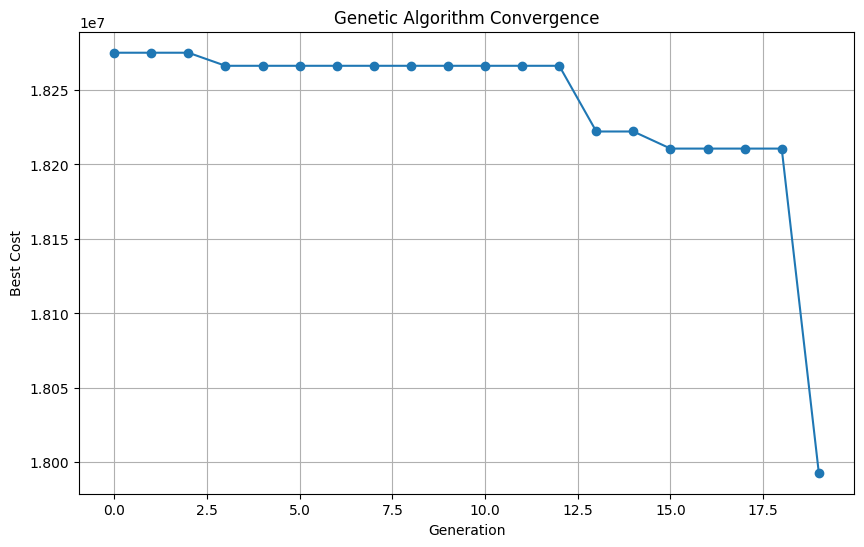

In [ ]:

# Run the main function
if __name__ == "__main__":
    main()